In [233]:
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers

print(tf.__version__)


warnings.filterwarnings("ignore", category=UserWarning) 

training_file = '../training_processed.csv'
testing_file = '../智能制造赛道测试集/test/testing.csv'

2.9.2


## 01 - loading and preprocess data

In [234]:
# load training & testing file
training = pd.read_csv(training_file, low_memory=False)
testing = pd.read_csv(testing_file, low_memory=False)

numerical_features = [
                      'oxygen_set_value', # '氧量设定值'
                      'primary_air_volume', # '一次风量'
                      'grate_manual_command',  #  '炉排手动指令'
                      'main_steam_flow_set_value', # '主蒸汽流量设定值'
                      'ejector_manual_command', #  '推料器手动指令'
                      'ejector_automatic_command', # '推料器自动指令'
                      'nox_content', # NOx含量
                      'grate_actual_operation_command', # 炉排实际运行指令
                      'secondary_air_control_door', # 二次风调门
                      'hcl_content', # HCL含量
                      'secondary_air_volume', # 二次风量
                      'water_flow', # 给水流量
                      'so2_content', # SO2含量
                      'drum_water_level', # 汽包水位
                      'induced_fan_speed', # 引风机转速
                      'co_content', # CO含量
                      'primary_damper' # 一次风调门
                      ] 

categorical_features = ['ejector_automatic_switching_signal', # '推料器自动投退信号'
                        'grate_automatic_switching_signal', # '炉排自动投退信号'
                        'pusher_on_or_off', # 推料器启停
                        'grate_on_or_off'] # 炉排启停

label = ['main_steam_flow']

In [235]:
training.head(1)

,datetime,oxygen_set_value,primary_air_volume,ejector_automatic_switching_signal,grate_automatic_switching_signal,grate_manual_command,main_steam_flow_set_value,ejector_manual_command,ejector_automatic_command,nox_content,...,secondary_air_volume,water_flow,so2_content,pusher_on_or_off,drum_water_level,induced_fan_speed,grate_on_or_off,co_content,primary_damper,main_steam_flow
0,2021-12-20 00:00:00,5.5,72919.6563,True,True,43.9083,60.0,53.9083,53.9094,57.4444,...,4330.127,73.4054,2.6458,True,1.6872,66.7986,True,1.6042,75.5532,54.3032


In [236]:
training.tail(1)

,datetime,oxygen_set_value,primary_air_volume,ejector_automatic_switching_signal,grate_automatic_switching_signal,grate_manual_command,main_steam_flow_set_value,ejector_manual_command,ejector_automatic_command,nox_content,...,secondary_air_volume,water_flow,so2_content,pusher_on_or_off,drum_water_level,induced_fan_speed,grate_on_or_off,co_content,primary_damper,main_steam_flow
257399,2021-12-22 23:29:59,25.0,72773.5469,False,False,50.0,60.0,40.0,70.0,111.5555,...,18553.9766,68.6189,3.2153,False,7.5527,67.4259,False,2.4583,65.5602,58.0246


## 02 feature engineering

In [237]:
# append traning and testing dataframe (apply feature engineering together, avoid training and serving skew)
# adding label column for testing dataset before merge
testing['main_steam_flow'] = 0
# concat 2 dataframe
data_all = pd.concat([training, testing], axis=0)
# sort
data_all.sort_values(by=['datetime'], ascending=True, inplace=True)

data_all.head(3)

,datetime,oxygen_set_value,primary_air_volume,ejector_automatic_switching_signal,grate_automatic_switching_signal,grate_manual_command,main_steam_flow_set_value,ejector_manual_command,ejector_automatic_command,nox_content,...,secondary_air_volume,water_flow,so2_content,pusher_on_or_off,drum_water_level,induced_fan_speed,grate_on_or_off,co_content,primary_damper,main_steam_flow
0,2021-12-20 00:00:00,5.5,72919.6563,True,True,43.9083,60.0,53.9083,53.9094,57.4444,...,4330.1270,73.4054,2.6458,True,1.6872,66.7986,True,1.6042,75.5532,54.3032
1,2021-12-20 00:00:01,5.5,73034.8047,True,True,44.0000,60.0,54.0000,54.0353,57.3889,...,4898.9800,73.5788,2.5833,True,1.6107,66.8056,True,1.5903,75.4144,54.1495
2,2021-12-20 00:00:02,5.5,73111.4609,True,True,44.0452,60.0,54.0452,54.0476,57.5556,...,4663.6895,73.7589,2.6181,True,1.5039,66.8195,True,1.6597,75.4051,54.4899


In [238]:
data_all.tail(3)

,datetime,oxygen_set_value,primary_air_volume,ejector_automatic_switching_signal,grate_automatic_switching_signal,grate_manual_command,main_steam_flow_set_value,ejector_manual_command,ejector_automatic_command,nox_content,...,secondary_air_volume,water_flow,so2_content,pusher_on_or_off,drum_water_level,induced_fan_speed,grate_on_or_off,co_content,primary_damper,main_steam_flow
1797,2021-12-22 23:59:57,25.0,79067.4688,True,True,50.0,60.0,100.0,100.0,71.6481,...,6244.9980,68.4506,35.2014,False,14.4141,69.5486,False,2.0278,70.8194,0.0
1798,2021-12-22 23:59:58,25.0,78748.0078,True,True,50.0,60.0,100.0,100.0,71.8519,...,6062.1777,68.4846,35.2500,False,14.3788,69.7292,False,2.0764,70.6875,0.0
1799,2021-12-22 23:59:59,25.0,78989.5000,True,True,50.0,60.0,100.0,100.0,72.0556,...,5612.4863,68.5730,33.7500,False,14.0503,69.9769,False,2.0069,70.5995,0.0


In [239]:
# one-encoding
onehot_encoding = pd.get_dummies(data_all[categorical_features].astype(str))
# concat back to previous dataframe
data_all = pd.concat([data_all, onehot_encoding], axis=1)
# drop previous column
data_all = data_all.drop(columns=categorical_features)
# save to local disk
# data_all.to_csv('../data_all.csv', index=False)

In [240]:
# normalization
scaler = MinMaxScaler()
# fit scaler
scaler.fit(data_all[numerical_features + label])
# print log
print(f"Scaler max value is {scaler.data_max_}, min value is {scaler.data_min_}")
# transform data
data_all[numerical_features + label] = scaler.transform(data_all[numerical_features + label])

Scaler max value is [7.00000000e+01 1.22637047e+05 1.00000000e+02 7.00361000e+01
 1.00000200e+02 1.00000200e+02 1.34537000e+02 1.00000000e+02
 8.99792000e+01 5.80046000e+01 3.57910586e+04 1.00297200e+02
 2.99617800e+02 4.69223000e+01 9.12498000e+01 3.00208100e+02
 1.00023100e+02 7.92595000e+01], min value is [ 2.88280000e+00  1.99712715e+04  3.00000000e+01  4.26552000e+01
  3.00000000e+01  4.00000000e+01  2.02778000e+01  2.99998000e+01
  9.68520000e+00  4.07400000e-01  0.00000000e+00  4.68703000e+01
 -1.45800000e-01 -2.79869000e+01  4.29398000e+01 -4.58100000e-01
  2.49977000e+01  0.00000000e+00]


In [241]:
data_all.head(1)

,datetime,oxygen_set_value,primary_air_volume,grate_manual_command,main_steam_flow_set_value,ejector_manual_command,ejector_automatic_command,nox_content,grate_actual_operation_command,secondary_air_control_door,...,primary_damper,main_steam_flow,ejector_automatic_switching_signal_False,ejector_automatic_switching_signal_True,grate_automatic_switching_signal_False,grate_automatic_switching_signal_True,pusher_on_or_off_False,pusher_on_or_off_True,grate_on_or_off_False,grate_on_or_off_True
0,2021-12-20 00:00:00,0.038994,0.515735,0.19869,0.633463,0.341546,0.231823,0.325283,0.198685,0.134258,...,0.673845,0.685132,0,1,0,1,0,1,0,1


In [242]:
# split data_all back to training and testing
training = data_all.iloc[:-1800]
testing = data_all.iloc[-1800:]

training.head(1)

,datetime,oxygen_set_value,primary_air_volume,grate_manual_command,main_steam_flow_set_value,ejector_manual_command,ejector_automatic_command,nox_content,grate_actual_operation_command,secondary_air_control_door,...,primary_damper,main_steam_flow,ejector_automatic_switching_signal_False,ejector_automatic_switching_signal_True,grate_automatic_switching_signal_False,grate_automatic_switching_signal_True,pusher_on_or_off_False,pusher_on_or_off_True,grate_on_or_off_False,grate_on_or_off_True
0,2021-12-20 00:00:00,0.038994,0.515735,0.19869,0.633463,0.341546,0.231823,0.325283,0.198685,0.134258,...,0.673845,0.685132,0,1,0,1,0,1,0,1


In [243]:
training.tail(1)

,datetime,oxygen_set_value,primary_air_volume,grate_manual_command,main_steam_flow_set_value,ejector_manual_command,ejector_automatic_command,nox_content,grate_actual_operation_command,secondary_air_control_door,...,primary_damper,main_steam_flow,ejector_automatic_switching_signal_False,ejector_automatic_switching_signal_True,grate_automatic_switching_signal_False,grate_automatic_switching_signal_True,pusher_on_or_off_False,pusher_on_or_off_True,grate_on_or_off_False,grate_on_or_off_True
257399,2021-12-22 23:29:59,0.329531,0.514312,0.285714,0.633463,0.142857,0.499998,0.798865,0.285716,0.495312,...,0.54065,0.732084,1,0,1,0,1,0,1,0


In [244]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257400 entries, 0 to 257399
Data columns (total 27 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   datetime                                  257400 non-null  object 
 1   oxygen_set_value                          257400 non-null  float64
 2   primary_air_volume                        257400 non-null  float64
 3   grate_manual_command                      257400 non-null  float64
 4   main_steam_flow_set_value                 257400 non-null  float64
 5   ejector_manual_command                    257400 non-null  float64
 6   ejector_automatic_command                 257400 non-null  float64
 7   nox_content                               257400 non-null  float64
 8   grate_actual_operation_command            257400 non-null  float64
 9   secondary_air_control_door                257400 non-null  float64
 10  hcl_content         

In [245]:
testing.head(1)

,datetime,oxygen_set_value,primary_air_volume,grate_manual_command,main_steam_flow_set_value,ejector_manual_command,ejector_automatic_command,nox_content,grate_actual_operation_command,secondary_air_control_door,...,primary_damper,main_steam_flow,ejector_automatic_switching_signal_False,ejector_automatic_switching_signal_True,grate_automatic_switching_signal_False,grate_automatic_switching_signal_True,pusher_on_or_off_False,pusher_on_or_off_True,grate_on_or_off_False,grate_on_or_off_True
0,2021-12-22 23:30:00,0.329531,0.515361,0.285714,0.633463,0.142857,0.499998,0.797569,0.285716,0.495286,...,0.540341,0.0,1,0,1,0,1,0,1,0


In [246]:
testing.tail(1)

,datetime,oxygen_set_value,primary_air_volume,grate_manual_command,main_steam_flow_set_value,ejector_manual_command,ejector_automatic_command,nox_content,grate_actual_operation_command,secondary_air_control_door,...,primary_damper,main_steam_flow,ejector_automatic_switching_signal_False,ejector_automatic_switching_signal_True,grate_automatic_switching_signal_False,grate_automatic_switching_signal_True,pusher_on_or_off_False,pusher_on_or_off_True,grate_on_or_off_False,grate_on_or_off_True
1799,2021-12-22 23:59:59,0.329531,0.574858,0.285714,0.633463,0.999997,0.999997,0.453161,0.285716,0.136997,...,0.607818,0.0,0,1,0,1,1,0,1,0


In [247]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 0 to 1799
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   datetime                                  1800 non-null   object 
 1   oxygen_set_value                          1800 non-null   float64
 2   primary_air_volume                        1800 non-null   float64
 3   grate_manual_command                      1800 non-null   float64
 4   main_steam_flow_set_value                 1800 non-null   float64
 5   ejector_manual_command                    1800 non-null   float64
 6   ejector_automatic_command                 1800 non-null   float64
 7   nox_content                               1800 non-null   float64
 8   grate_actual_operation_command            1800 non-null   float64
 9   secondary_air_control_door                1800 non-null   float64
 10  hcl_content                         

## 02 - modeling - rnn

### 2.1 train LSTM model

In [248]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in  enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    
    def make_dataset(self, data, is_shuffle=True):
        ata = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=is_shuffle,
            batch_size=32,)
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def val2(self):
        return self.make_dataset(self.val_df, False) # dont shuffle


    @property
    def test(self):
        return self.make_dataset(self.test_df, False) # dont shuffle

In [249]:
MAX_EPOCHS = 200
patience = 3

# init model
model_lstm = Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32, return_sequences=True),
    layers.Dense(1)
])

# define early stoping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                  mode='min')

# compile model
model_lstm.compile(loss=keras.losses.MeanSquaredError(),
                   optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                   metrics=[keras.metrics.MeanAbsoluteError()])


model_lstm

In [250]:
# retrieve features and labels
x = training[numerical_features + label]

# split training data into train and validation (latest 1800 records for validation, remaining for training)
val_num = 7200
x_train = x[:-val_num]
x_val = x[-val_num:]

input_width = 5 # how many time steps are using
label_width = 1 # how many labels are predicted one at time
shift = 1 # offset between input feature and label

# init window generator
w_lstm = WindowGenerator(input_width, 
                         label_width,
                         shift,
                         train_df=x_train,
                         val_df=x_val,
                         test_df=x_test,
                         label_columns=label)

w_lstm

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['main_steam_flow']

In [251]:
x_val.head()

,oxygen_set_value,primary_air_volume,grate_manual_command,main_steam_flow_set_value,ejector_manual_command,ejector_automatic_command,nox_content,grate_actual_operation_command,secondary_air_control_door,hcl_content,secondary_air_volume,water_flow,so2_content,drum_water_level,induced_fan_speed,co_content,primary_damper,main_steam_flow
250200,0.046444,0.806809,0.285714,0.633463,0.357142,0.499998,0.567585,0.285716,0.002133,0.029097,0.0,0.543576,0.000509,0.439999,0.836371,0.012010,0.862640,0.780735
250201,0.046444,0.804631,0.285714,0.633463,0.357142,0.499998,0.568720,0.285716,0.001873,0.029017,0.0,0.546335,0.000464,0.439874,0.836994,0.011940,0.862732,0.777933
250202,0.046444,0.806066,0.285714,0.633463,0.357142,0.499998,0.566613,0.285716,0.001384,0.029580,0.0,0.548928,0.000394,0.438918,0.838911,0.012079,0.862825,0.778037
250203,0.046444,0.807499,0.285714,0.633463,0.357142,0.499998,0.567747,0.285716,0.001701,0.029821,0.0,0.549562,0.000232,0.439042,0.837282,0.011871,0.862732,0.777952
250204,0.046444,0.801594,0.285714,0.633463,0.357142,0.499998,0.525932,0.285716,0.001759,0.029097,0.0,0.549802,0.000302,0.439180,0.832490,0.012171,0.862732,0.778433


In [252]:
for example_inputs, example_labels in w_lstm.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    
    print(example_inputs[0])
    print(example_labels[0])

Inputs shape (batch, time, features): (32, 5, 18)
Labels shape (batch, time, features): (32, 1, 1)
tf.Tensor(
[[0.10679379 0.74565564 0.57142857 0.26744921 0.4285702  0.33333222
  0.40470002 0.5714298  0.00138616 0.0843982  0.         0.44877019
  0.02900419 0.32357574 0.66574415 0.01207884 0.87599933 0.63003552]
 [0.10677293 0.7362247  0.57142857 0.26672973 0.4285702  0.33333222
  0.40470002 0.5714298  0.00138616 0.08463953 0.         0.45213741
  0.0291433  0.32640183 0.66512109 0.01200966 0.87609263 0.62994089]
 [0.10663883 0.72842619 0.57142857 0.26889547 0.4285702  0.33333222
  0.40356575 0.5714298  0.00121304 0.084801   0.         0.4560156
  0.02911995 0.3298767  0.66483337 0.0121713  0.87587537 0.63232042]
 [0.1065852  0.72957715 0.57142857 0.2671826  0.4285702  0.33333222
  0.41361396 0.5714298  0.00155927 0.07989798 0.         0.46025878
  0.02689619 0.33344502 0.6640178  0.01207884 0.87609263 0.63338653]
 [0.1065405  0.73101392 0.57142857 0.26923512 0.4285702  0.33333222
  0

In [253]:
history = model_lstm.fit(w_lstm.train, 
                         epochs=MAX_EPOCHS,
                         validation_data=w_lstm.val,
                         callbacks=[early_stopping])

Epoch 1/200
7819/7819 [==============================] - 39s 5ms/step - loss: 0.0014 - mean_absolute_error: 0.0103 - val_loss: 1.4541e-05 - val_mean_absolute_error: 0.0028
Epoch 2/200
7819/7819 [==============================] - 39s 5ms/step - loss: 1.5346e-05 - mean_absolute_error: 0.0030 - val_loss: 1.2488e-05 - val_mean_absolute_error: 0.0026
Epoch 3/200
7819/7819 [==============================] - 36s 5ms/step - loss: 1.2715e-05 - mean_absolute_error: 0.0027 - val_loss: 2.1435e-05 - val_mean_absolute_error: 0.0027
Epoch 4/200
7819/7819 [==============================] - 38s 5ms/step - loss: 1.1138e-05 - mean_absolute_error: 0.0025 - val_loss: 1.8457e-05 - val_mean_absolute_error: 0.0032
Epoch 5/200
7819/7819 [==============================] - 38s 5ms/step - loss: 1.0243e-05 - mean_absolute_error: 0.0024 - val_loss: 1.7699e-05 - val_mean_absolute_error: 0.0029


### Evaluate prediction

In [254]:
%%time
model_lstm.evaluate(w_lstm.val)

225/225 [==============================] - 1s 2ms/step - loss: 1.7699e-05 - mean_absolute_error: 0.0029
CPU times: user 1.85 s, sys: 614 ms, total: 2.46 s
Wall time: 591 ms


[1.7698710507829674e-05, 0.002923810388892889]

In [255]:
%%time
model_lstm.evaluate(w_lstm.val2)

225/225 [==============================] - 1s 2ms/step - loss: 1.7699e-05 - mean_absolute_error: 0.0029
CPU times: user 1.62 s, sys: 564 ms, total: 2.19 s
Wall time: 552 ms


[1.7698705050861463e-05, 0.0029238106217235327]

In [256]:
predictions = model_lstm.predict(w_lstm.val2)

225/225 [==============================] - 1s 2ms/step


In [257]:
predictions.shape

(7195, 5, 1)

In [258]:
true_pred = np.concatenate(([0.780735], predictions[0][:4].reshape(4), predictions[:, 4, :].reshape(7195)), axis=0)
len(true_pred)

7200

In [259]:
x_val['prediction'] = true_pred

<ipython-input-259-852608c151c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['prediction'] = true_pred


In [272]:
# inverse to previous value
x_val_inversed = scaler.inverse_transform(x_val[x_val.columns[:-1]])
x_val_inversed_prediction = scaler.inverse_transform(x_val[['oxygen_set_value', 'primary_air_volume', 'grate_manual_command',
       'main_steam_flow_set_value', 'ejector_manual_command',
       'ejector_automatic_command', 'nox_content',
       'grate_actual_operation_command', 'secondary_air_control_door',
       'hcl_content', 'secondary_air_volume', 'water_flow', 'so2_content',
       'drum_water_level', 'induced_fan_speed', 'co_content',
       'primary_damper','prediction']])

<AxesSubplot:>

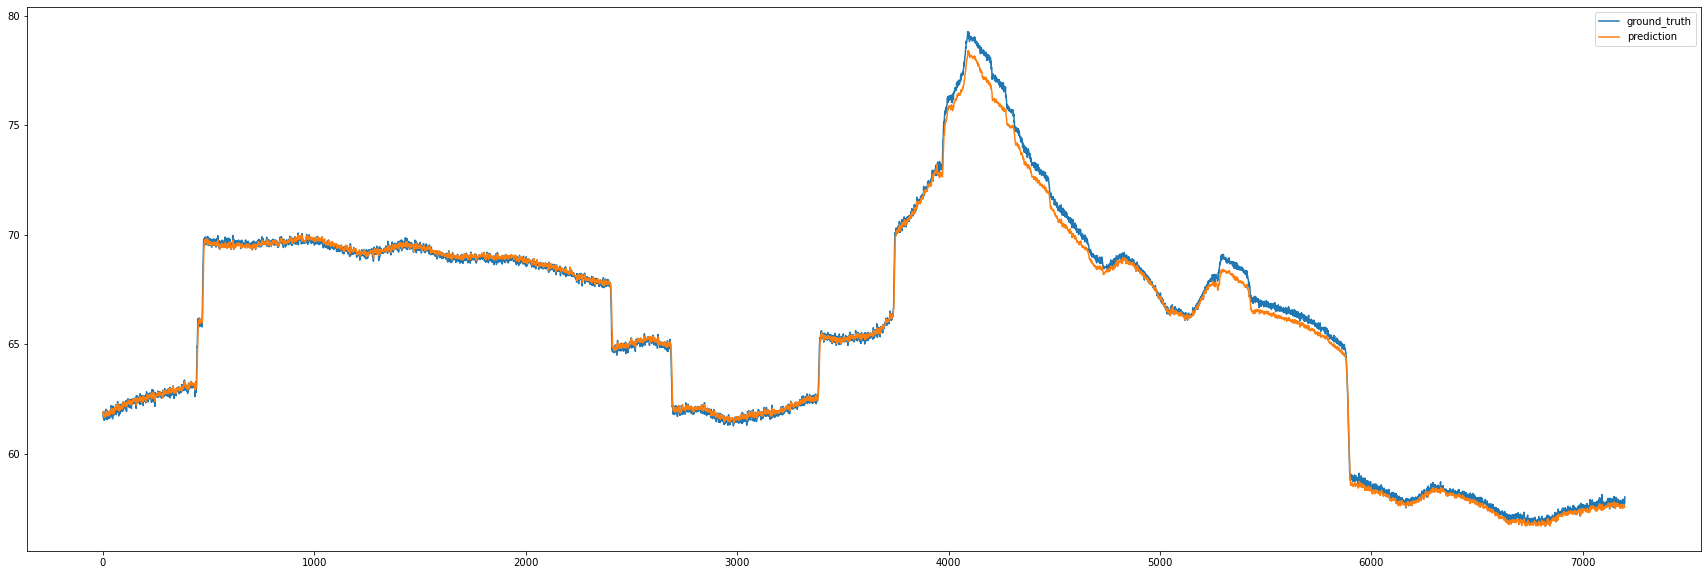

In [274]:
# append predictions with ground truth
val_df = pd.DataFrame(data={#'datetime': training.iloc[-val_num:]['datetime'],
                            'ground_truth': x_val_inversed[:,-1],
                            'prediction': x_val_inversed_prediction[:,-1]
                           })

# val_df.index = pd.to_datetime(val_df['datetime'], format='%Y-%m-%d %X')

# plot ground truth vs predictions
val_df[['ground_truth', 'prediction']].plot.line(figsize=(30, 10))

<AxesSubplot:>

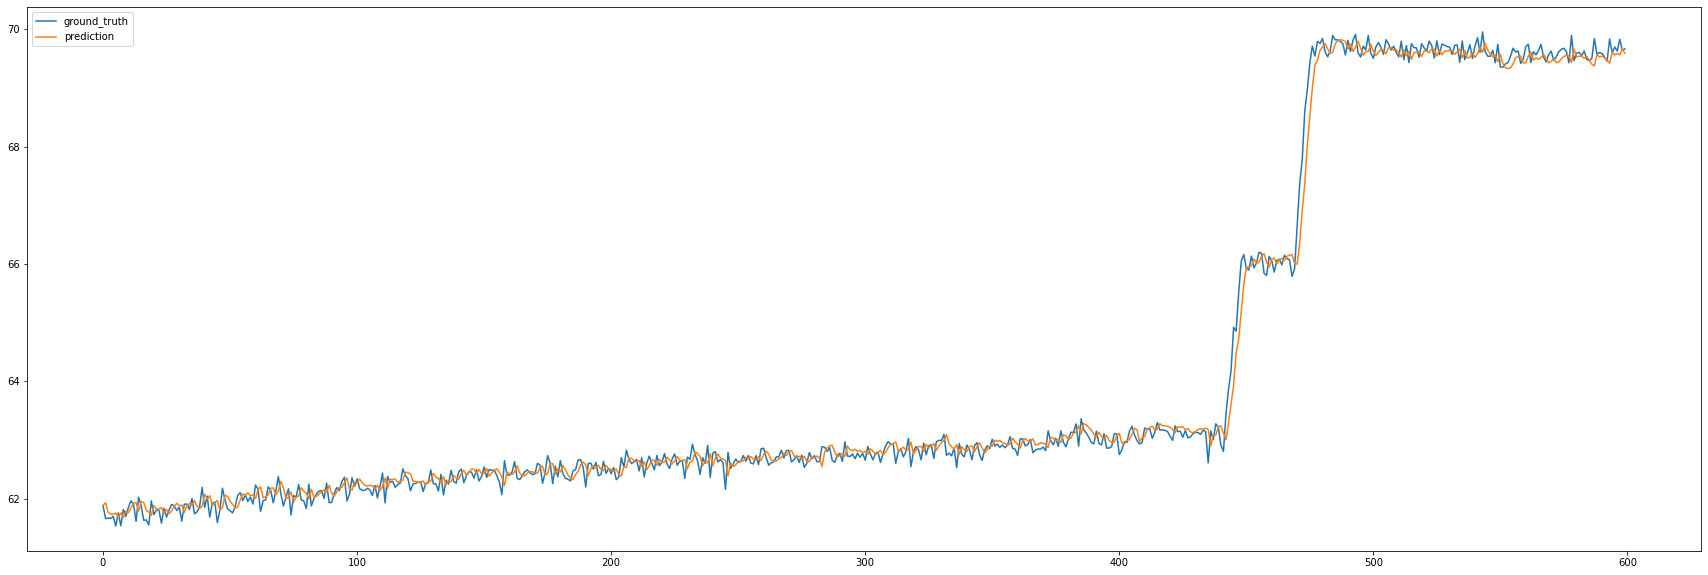

In [277]:
# plot ground truth vs predictions
val_df[['ground_truth', 'prediction']].head(600).plot.line(figsize=(30, 10))

<AxesSubplot:>

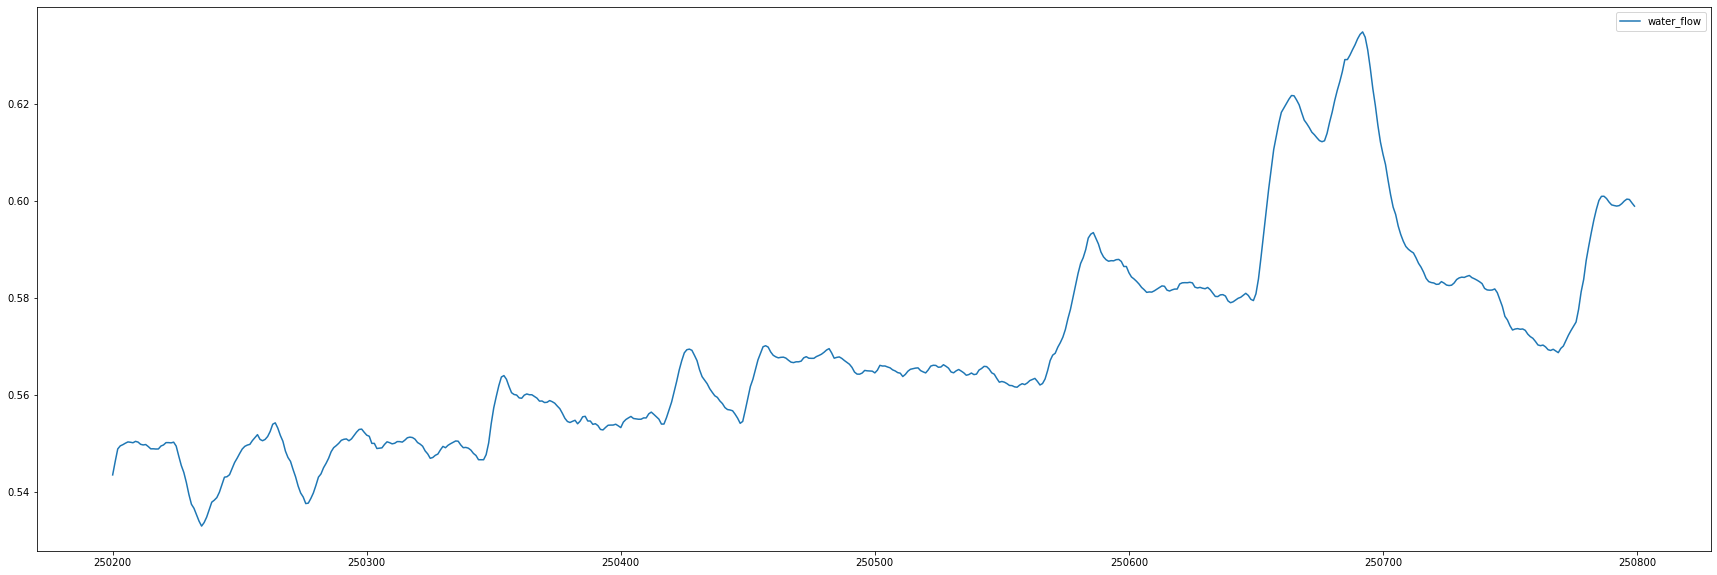

In [279]:
# plot ground truth vs predictions
x_val[['water_flow']].head(600).plot.line(figsize=(30, 10))

In [280]:
# retrieve last 5 records from validation and append to test
x_submission = pd.concat([x_val[-5:], testing[numerical_features + label]], axis=0)
x_submission = x_submission[numerical_features + label]
x_submission.head(10)

,oxygen_set_value,primary_air_volume,grate_manual_command,main_steam_flow_set_value,ejector_manual_command,ejector_automatic_command,nox_content,grate_actual_operation_command,secondary_air_control_door,hcl_content,secondary_air_volume,water_flow,so2_content,drum_water_level,induced_fan_speed,co_content,primary_damper,main_steam_flow
257395,0.329531,0.514087,0.285714,0.633463,0.142857,0.499998,0.799676,0.285716,0.496119,0.038903,0.517832,0.407222,0.009799,0.479310,0.506518,0.009192,0.540341,0.729007
257396,0.329531,0.513037,0.285714,0.633463,0.142857,0.499998,0.799190,0.285716,0.495774,0.041073,0.518397,0.406939,0.011351,0.478085,0.507094,0.009977,0.540341,0.729234
257397,0.329531,0.509195,0.285714,0.633463,0.142857,0.499998,0.800162,0.285716,0.495485,0.041637,0.521774,0.406913,0.011328,0.476632,0.507237,0.009908,0.540341,0.728869
257398,0.329531,0.511457,0.285714,0.633463,0.142857,0.499998,0.798865,0.285716,0.495485,0.041797,0.520088,0.407061,0.011560,0.475127,0.507477,0.009769,0.540557,0.728502
257399,0.329531,0.514312,0.285714,0.633463,0.142857,0.499998,0.798865,0.285716,0.495312,0.042601,0.518397,0.407072,0.011213,0.474436,0.506854,0.009700,0.540650,0.732084
0,0.329531,0.515361,0.285714,0.633463,0.142857,0.499998,0.797569,0.285716,0.495286,0.042118,0.518397,0.407695,0.011351,0.474122,0.506566,0.009931,0.540341,0.000000
1,0.329531,0.523623,0.285714,0.633463,0.142857,0.499998,0.797569,0.285716,0.495084,0.041877,0.516133,0.407922,0.011421,0.473577,0.506663,0.009908,0.540557,0.000000
2,0.329531,0.528418,0.285714,0.633463,0.142857,0.499998,0.798056,0.285716,0.495545,0.040834,0.518397,0.407475,0.011560,0.472974,0.507286,0.010046,0.540465,0.000000
3,0.329531,0.522364,0.285714,0.633463,0.142857,0.499998,0.779416,0.285716,0.495863,0.036493,0.518397,0.407130,0.010147,0.473353,0.506951,0.004965,0.540156,0.000000
4,0.329531,0.517081,0.285714,0.633463,0.142857,0.499998,0.778769,0.285716,0.495747,0.036411,0.520088,0.406939,0.009938,0.474533,0.507286,0.004757,0.540465,0.000000


In [281]:
x_submission.tail(10)

,oxygen_set_value,primary_air_volume,grate_manual_command,main_steam_flow_set_value,ejector_manual_command,ejector_automatic_command,nox_content,grate_actual_operation_command,secondary_air_control_door,hcl_content,secondary_air_volume,water_flow,so2_content,drum_water_level,induced_fan_speed,co_content,primary_damper,main_steam_flow
1790,0.329531,0.572159,0.285714,0.633463,0.999997,0.999997,0.464992,0.285716,0.146452,0.031349,0.181072,0.406065,0.114372,0.600464,0.577243,0.008499,0.608127,0.0
1791,0.329531,0.575548,0.285714,0.633463,0.999997,0.999997,0.452512,0.285716,0.140023,0.031026,0.185858,0.405970,0.117801,0.598522,0.572596,0.008476,0.607633,0.0
1792,0.329531,0.592140,0.285714,0.633463,0.999997,0.999997,0.451378,0.285716,0.135353,0.031267,0.185858,0.405578,0.118148,0.592242,0.568187,0.008406,0.607541,0.0
1793,0.329531,0.593827,0.285714,0.633463,0.999997,0.999997,0.449757,0.285716,0.135440,0.031508,0.181072,0.405595,0.117986,0.582106,0.563300,0.008337,0.607602,0.0
1794,0.329531,0.589230,0.285714,0.633463,0.999997,0.999997,0.449594,0.285716,0.137746,0.031991,0.185858,0.405303,0.117871,0.572826,0.557884,0.008360,0.610009,0.0
1795,0.329531,0.584196,0.285714,0.633463,0.999997,0.999997,0.448136,0.285716,0.137400,0.031590,0.174485,0.404899,0.117778,0.569077,0.552710,0.008198,0.611891,0.0
1796,0.329531,0.581735,0.285714,0.633463,0.999997,0.999997,0.449594,0.285716,0.136968,0.030786,0.174485,0.404145,0.117778,0.567071,0.549644,0.008291,0.612199,0.0
1797,0.329531,0.575617,0.285714,0.633463,0.999997,0.999997,0.449594,0.285716,0.136506,0.030786,0.174485,0.403922,0.117917,0.566032,0.550793,0.008268,0.610749,0.0
1798,0.329531,0.572506,0.285714,0.633463,0.999997,0.999997,0.451378,0.285716,0.137457,0.031508,0.169377,0.404558,0.118079,0.565561,0.554531,0.008430,0.608991,0.0
1799,0.329531,0.574858,0.285714,0.633463,0.999997,0.999997,0.453161,0.285716,0.136997,0.031750,0.156813,0.406213,0.113075,0.561175,0.559658,0.008198,0.607818,0.0


### rolling prediction

In [282]:
# calc number of iteration
num_iteration = x_submission.shape[0]
# define start index and end index
s_idx, e_idx = 0, input_width

for i in range(0, num_iteration+1):
    # retrieve input features
    input_features = x_submission.iloc[s_idx:e_idx]
    # make prediction
    pred = model_lstm.predict(input_features.values.reshape(1, 5, -1))
    # update prediction in dataframe as next step feature input
    x_submission.iloc[e_idx]['main_steam_flow'] = pred[0][-1][0]
    # increase start and end idx
    s_idx += 1
    e_idx += 1

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


IndexError: single positional indexer is out-of-bounds

In [ ]:
x_submission.head(10)

In [ ]:
x_submission.tail(10)

In [ ]:
# inverse to previous value
x_submission_inversed = scaler.inverse_transform(x_submission)
x_submission_inversed

In [ ]:
x_submission_inversed[5:,2]

In [ ]:
# generate submission file
submission_file = pd.DataFrame(data={'ID':[i for i in range(1, 1801)], 
                                     'Time':testing['datetime'].values, 
                                     'Steam_flow':x_submission_inversed[5:,3],
                                     'Water_flow':x_submission_inversed[5:,2]})
submission_file.head()

In [ ]:
# plot predictions
date_time = pd.to_datetime(submission_file['Time'], format='%Y-%m-%d %H:%M:%S')
plot_cols = ['Steam_flow', 'Water_flow']
plot_features = submission_file[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize=(20, 8))

In [218]:
submission_file.head()

,ID,Time,Steam_flow,Water_flow
0,1,2021-12-22 23:30:00,57.980486,68.6522
1,2,2021-12-22 23:30:01,58.004919,68.6643
2,3,2021-12-22 23:30:02,58.024823,68.6404
3,4,2021-12-22 23:30:03,58.044225,68.6220
4,5,2021-12-22 23:30:04,58.061048,68.6118


In [219]:
# define output columns
output_columns = ['ID','Time','Steam_flow']

# write to local disk
submission_file[output_columns].to_csv('../submission_lstm.csv', index=False)

In [220]:
submission_file[output_columns].head()

,ID,Time,Steam_flow
0,1,2021-12-22 23:30:00,57.980486
1,2,2021-12-22 23:30:01,58.004919
2,3,2021-12-22 23:30:02,58.024823
3,4,2021-12-22 23:30:03,58.044225
4,5,2021-12-22 23:30:04,58.061048


In [ ]:
# final test score 4.5